In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, recall_score, precision_score, precision_recall_curve
import torch
from sklearn.model_selection import train_test_split


In [2]:
#!pip install maru

In [3]:
import maru

In [4]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.shape , test.shape

((63438, 5), (29960, 4))

In [5]:
features = pd.concat([train.drop(['stress'], axis=1), test]) 

In [6]:
labels = train.stress

In [7]:
train.shape , test.shape, features.shape

((63438, 5), (29960, 4), (93398, 4))

In [8]:
features.head()

,id,word,num_syllables,lemma
0,0,румяной,3,румяный
1,1,цифрами,3,цифра
2,2,слугами,3,слуга
3,3,выбирает,4,выбирать
4,4,управдом,3,управдом


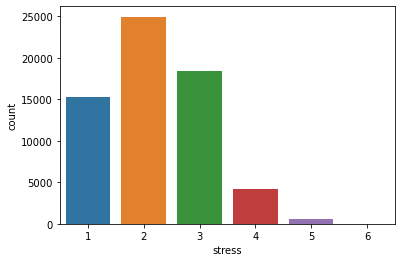

In [9]:
sns.countplot(x=train.stress)
plt.show()

In [10]:
train.stress.unique()

array([2, 1, 3, 4, 5, 6])

In [11]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93398 entries, 0 to 29959
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             93398 non-null  int64 
 1   word           93398 non-null  object
 2   num_syllables  93398 non-null  int64 
 3   lemma          93398 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.6+ MB


In [12]:
def LCS(stringA, stringB):
    lenStringA = 1 + len(stringA)
    lenStringB = 1 + len(stringB)

    matrix = [[0] * (lenStringB) for i in range(lenStringA)]

    substringLength = 0
    endIndex = 0

    for aIndex in range(1, lenStringA):
        for bIndex in range(1, lenStringB):

            if stringA[aIndex - 1] == stringB[bIndex - 1]:

                matrix[aIndex][bIndex] = matrix[aIndex - 1][bIndex - 1] + 1

                if matrix[aIndex][bIndex] > substringLength:

                    substringLength = matrix[aIndex][bIndex]
                    endIndex = aIndex

            else:

                matrix[aIndex][bIndex] = 0

    return stringA[endIndex - substringLength: endIndex]

In [13]:
features['maxsubstring_len'] = features.apply(lambda x: len(LCS(x.word, x.lemma)), axis=1)

In [14]:
features.head()

,id,word,num_syllables,lemma,maxsubstring_len
0,0,румяной,3,румяный,5
1,1,цифрами,3,цифра,5
2,2,слугами,3,слуга,5
3,3,выбирает,4,выбирать,6
4,4,управдом,3,управдом,8


In [15]:
features['is_cia'] = features.word.apply(lambda x: (x[-3:] == 'ция')*1)

In [16]:
features[features.is_cia==1.0].describe()

,id,num_syllables,maxsubstring_len,is_cia
count,228.000000,228.000000,228.000000,228.0
mean,28229.868421,4.934211,9.824561,1.0
std,18339.493567,0.839585,1.910996,0.0
min,79.000000,3.000000,5.000000,1.0
25%,11462.750000,4.000000,9.000000,1.0
50%,26151.000000,5.000000,10.000000,1.0
75%,42376.250000,6.000000,11.000000,1.0
max,62952.000000,6.000000,15.000000,1.0


In [17]:
glass = {'а', 'о', 'у', 'э', 'ы', 'я', 'ё', 'ю', 'я', 'и'}

In [18]:
features[:len(train)]

,id,word,num_syllables,lemma,maxsubstring_len,is_cia
0,0,румяной,3,румяный,5,0
1,1,цифрами,3,цифра,5,0
2,2,слугами,3,слуга,5,0
3,3,выбирает,4,выбирать,6,0
4,4,управдом,3,управдом,8,0
...,...,...,...,...,...,...
63433,63433,экзамена,4,экзамен,7,0
63434,63434,культурой,3,культура,7,0
63435,63435,объемной,3,объемный,6,0
63436,63436,участком,3,участок,5,0


In [19]:

features['word'] = features.word.apply(lambda x: x.replace("ё", "е"))
features[features.word.str.find("ё")!=-1]

,id,word,num_syllables,lemma,maxsubstring_len,is_cia


In [20]:
analyzer = maru.get_analyzer(tagger='crf', lemmatizer='pymorphy')
analyzed = features.word.to_list()
#analyzed = analyzer.analyze(analyzed)
tags_morth = []

In [21]:
analyzed = analyzer.analyze(analyzed)
for morph in analyzed:
    tags_morth.append(morph.tag)

In [22]:
pos = pd.DataFrame([x.pos for x in tags_morth], columns=['Part_of_speach'])
print(pos.Part_of_speach.unique())
pos.Part_of_speach = pos.Part_of_speach.apply(lambda x: str(x)[str(x).find('.')+1:])
pos.Part_of_speach.unique()


[ADJ NOUN VERB NUM ADV PRON H ADP DET CONJ PART INTJ UNKN]


array(['ADJECTIVE', 'NOUN', 'VERB', 'NUMERICAL', 'ADVERB', 'PRONOUN',
       'INTRODUCTION', 'ADPOSITION', 'DETERMINANT', 'CONJUNCTION',
       'PARTICLE', 'INTERJECTION', 'UNKNOWN'], dtype=object)

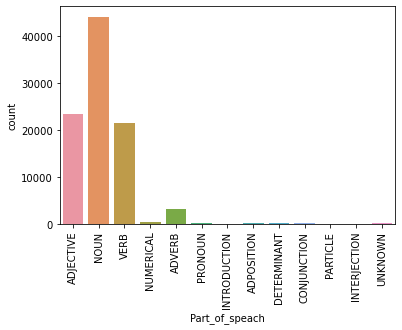

In [23]:
sns.countplot(x=pos.Part_of_speach)
plt.xticks(rotation = 90)
plt.show()

In [24]:
features['Part_of_speach'] = pos
features

,id,word,num_syllables,lemma,maxsubstring_len,is_cia,Part_of_speach
0,0,румяной,3,румяный,5,0,ADJECTIVE
1,1,цифрами,3,цифра,5,0,NOUN
2,2,слугами,3,слуга,5,0,NOUN
3,3,выбирает,4,выбирать,6,0,VERB
4,4,управдом,3,управдом,8,0,NOUN
...,...,...,...,...,...,...,...
29955,29955,донбасса,3,донбасс,7,0,NOUN
29956,29956,обложка,3,обложка,7,0,NOUN
29957,29957,правителя,4,правитель,8,0,ADJECTIVE
29958,29958,шерстяной,3,шерстяной,9,0,NOUN


In [25]:
features[features.Part_of_speach == 'DETERMINANT']

,id,word,num_syllables,lemma,maxsubstring_len,is_cia,Part_of_speach
473,473,этакая,4,этакий,4,0,DETERMINANT
526,526,таковыми,4,таковой,5,0,DETERMINANT
1533,1533,многому,3,многое,5,0,DETERMINANT
1803,1803,ихние,3,ихний,4,0,DETERMINANT
2236,2236,марлю,2,марля,4,0,DETERMINANT
...,...,...,...,...,...,...,...
25739,25739,опорной,3,опорный,5,0,DETERMINANT
25977,25977,заднюю,3,задний,4,0,DETERMINANT
27469,27469,метафизика,5,метафизика,10,0,DETERMINANT
28054,28054,радужно,3,радужно,7,0,DETERMINANT


In [26]:
pos = pd.DataFrame([x.animacy for x in tags_morth], columns=['animacy'])
print(pos.animacy.unique())
pos.animacy = pos.animacy.apply(lambda x: str(x)[str(x).find('.')+1:] if x else  None)
pos.animacy.unique()

[None Inan Anim]


array([None, 'INANIMATE', 'ANIMATE'], dtype=object)

<class 'pandas.core.series.Series'>
RangeIndex: 93398 entries, 0 to 93397
Series name: animacy
Non-Null Count  Dtype 
--------------  ----- 
44131 non-null  object
dtypes: object(1)
memory usage: 729.8+ KB
None


<AxesSubplot:xlabel='animacy', ylabel='count'>

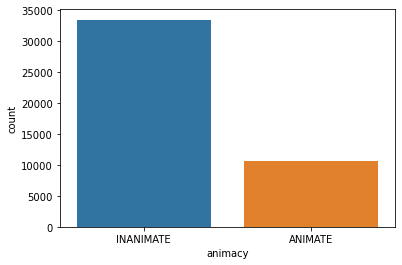

In [27]:
print(pos.animacy.info())
sns.countplot(x=pos.animacy)

<AxesSubplot:xlabel='animacy', ylabel='count'>

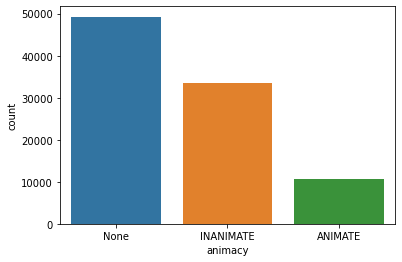

In [28]:
pos.animacy.fillna("None", inplace=True)
sns.countplot(x=pos.animacy)

In [29]:
pos['aspect'] = pd.DataFrame([x.aspect for x in tags_morth], columns=['aspect'])
print(pos.aspect.unique())
pos.aspect = pos.aspect.apply(lambda x: str(x)[str(x).find('.')+1:] if x else  None)
pos.aspect.unique()

[None Imp Perf]


array([None, 'IMPERFECT', 'PERFECT'], dtype=object)

<AxesSubplot:xlabel='aspect', ylabel='count'>

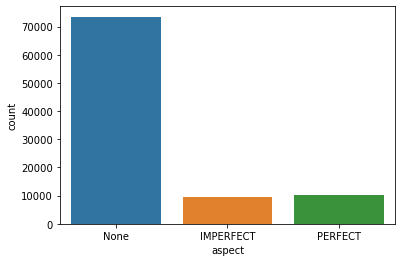

In [30]:
pos.aspect.fillna("None", inplace=True)
sns.countplot(x=pos.aspect)

In [31]:
attribute_maru = ['case','degree','gender','mood', 'number', 'numform', 'person', 'tense',
                 'variant', 'verbform', 'voice']

[Ins None Acc Gen Nom Dat Loc]


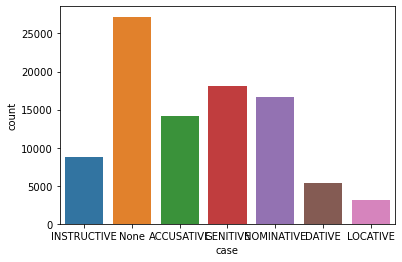

[Pos None Cmp]


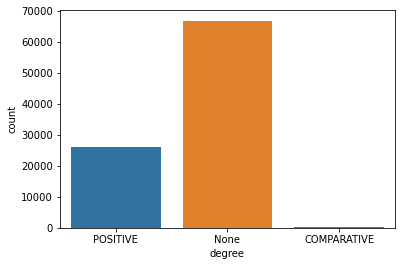

[Fem Masc None Neut]


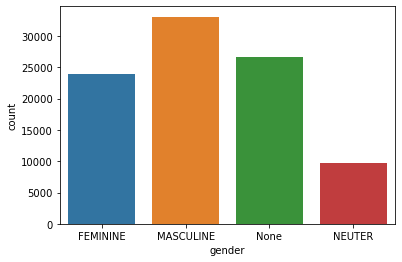

[None Ind Imp]


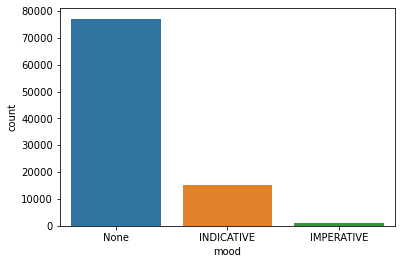

[Sing Plur None]


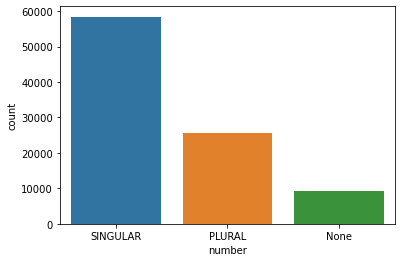

[None]


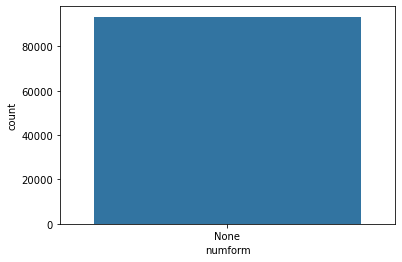

[None 3 2 1]


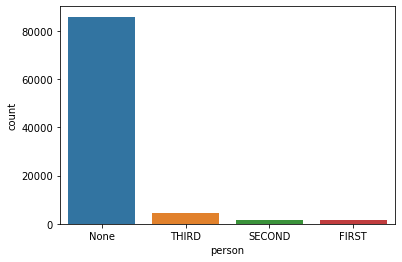

[None Pres Past Fut]


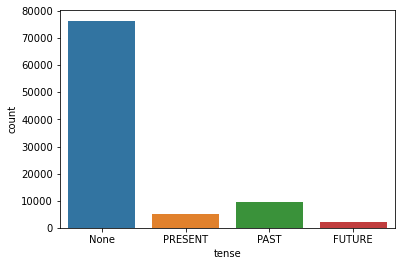

[Full None Short]


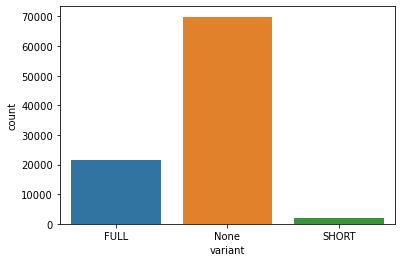

[None Fin Inf Conv]


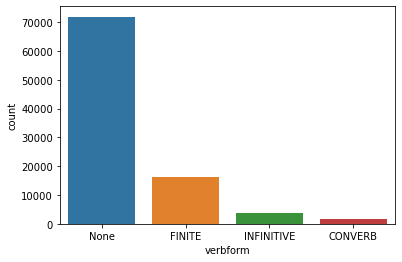

[None Act Mid]


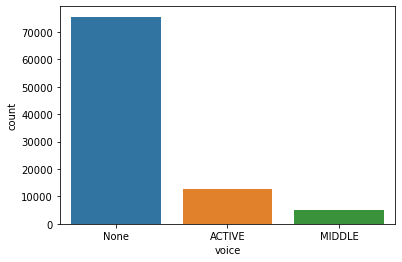

In [32]:
for atr in attribute_maru:
    pos[atr] = pd.DataFrame([getattr(x, atr) for x in tags_morth], columns=[atr])
    print(pos[atr].unique())
    pos[atr] = pos[atr].apply(lambda x: str(x)[str(x).find('.')+1:] if x else  None)
    pos[atr].unique()
    pos[atr].fillna("None", inplace=True)
    sns.countplot(x=pos[atr])
    plt.show()

In [33]:
#     pos: PartOfSpeech
#     animacy: Optional[Animacy] = None
#     aspect: Optional[Aspect] = None
#     case: Optional[Case] = None
#     degree: Optional[Degree] = None
#     gender: Optional[Gender] = None
#     mood: Optional[Mood] = None
#     number: Optional[Number] = None
#     numform: Optional[NumericalForm] = None
#     person: Optional[Person] = None
#     tense: Optional[Tense] = None
#     variant: Optional[Variant] = None
#     verbform: Optional[VerbForm] = None
#     voice: Optional[Voice] = None

In [34]:
pos.numform.unique()

array(['None'], dtype=object)

In [35]:
pos.drop(['numform'],axis=1, inplace=True)

In [36]:
pos

,animacy,aspect,case,degree,gender,mood,number,person,tense,variant,verbform,voice
0,None,None,INSTRUCTIVE,POSITIVE,FEMININE,None,SINGULAR,None,None,FULL,None,None
1,INANIMATE,None,INSTRUCTIVE,None,FEMININE,None,PLURAL,None,None,None,None,None
2,ANIMATE,None,INSTRUCTIVE,None,MASCULINE,None,PLURAL,None,None,None,None,None
3,None,IMPERFECT,None,None,None,INDICATIVE,SINGULAR,THIRD,PRESENT,None,FINITE,ACTIVE
4,ANIMATE,None,INSTRUCTIVE,None,MASCULINE,None,SINGULAR,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
93393,INANIMATE,None,GENITIVE,None,MASCULINE,None,SINGULAR,None,None,None,None,None
93394,INANIMATE,None,NOMINATIVE,None,FEMININE,None,SINGULAR,None,None,None,None,None
93395,ANIMATE,None,GENITIVE,None,MASCULINE,None,SINGULAR,None,None,None,None,None
93396,None,None,GENITIVE,POSITIVE,FEMININE,None,SINGULAR,None,None,FULL,None,None


In [37]:
for col in pos.columns:
    features[col] = pos[col]

In [38]:
features.head()

,id,word,num_syllables,lemma,maxsubstring_len,is_cia,Part_of_speach,animacy,aspect,case,degree,gender,mood,number,person,tense,variant,verbform,voice
0,0,румяной,3,румяный,5,0,ADJECTIVE,None,None,INSTRUCTIVE,POSITIVE,FEMININE,None,SINGULAR,None,None,FULL,None,None
1,1,цифрами,3,цифра,5,0,NOUN,INANIMATE,None,INSTRUCTIVE,None,FEMININE,None,PLURAL,None,None,None,None,None
2,2,слугами,3,слуга,5,0,NOUN,ANIMATE,None,INSTRUCTIVE,None,MASCULINE,None,PLURAL,None,None,None,None,None
3,3,выбирает,4,выбирать,6,0,VERB,None,IMPERFECT,None,None,None,INDICATIVE,SINGULAR,THIRD,PRESENT,None,FINITE,ACTIVE
4,4,управдом,3,управдом,8,0,NOUN,ANIMATE,None,INSTRUCTIVE,None,MASCULINE,None,SINGULAR,None,None,None,None,None


In [39]:
features.shape

(93398, 19)

In [40]:
attribute_maru.pop(attribute_maru.index('numform'))
features = pd.get_dummies(data=features, columns=attribute_maru)


In [41]:
features.shape

(93398, 47)

In [42]:
features = pd.get_dummies(data=features, columns=['Part_of_speach', 'animacy', 'aspect'])

In [43]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93398 entries, 0 to 29959
Data columns (total 63 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           93398 non-null  int64 
 1   word                         93398 non-null  object
 2   num_syllables                93398 non-null  int64 
 3   lemma                        93398 non-null  object
 4   maxsubstring_len             93398 non-null  int64 
 5   is_cia                       93398 non-null  int64 
 6   case_ACCUSATIVE              93398 non-null  uint8 
 7   case_DATIVE                  93398 non-null  uint8 
 8   case_GENITIVE                93398 non-null  uint8 
 9   case_INSTRUCTIVE             93398 non-null  uint8 
 10  case_LOCATIVE                93398 non-null  uint8 
 11  case_NOMINATIVE              93398 non-null  uint8 
 12  case_None                    93398 non-null  uint8 
 13  degree_COMPARATIVE           93

In [44]:
features.columns

Index(['id', 'word', 'num_syllables', 'lemma', 'maxsubstring_len', 'is_cia',
       'case_ACCUSATIVE', 'case_DATIVE', 'case_GENITIVE', 'case_INSTRUCTIVE',
       'case_LOCATIVE', 'case_NOMINATIVE', 'case_None', 'degree_COMPARATIVE',
       'degree_None', 'degree_POSITIVE', 'gender_FEMININE', 'gender_MASCULINE',
       'gender_NEUTER', 'gender_None', 'mood_IMPERATIVE', 'mood_INDICATIVE',
       'mood_None', 'number_None', 'number_PLURAL', 'number_SINGULAR',
       'person_FIRST', 'person_None', 'person_SECOND', 'person_THIRD',
       'tense_FUTURE', 'tense_None', 'tense_PAST', 'tense_PRESENT',
       'variant_FULL', 'variant_None', 'variant_SHORT', 'verbform_CONVERB',
       'verbform_FINITE', 'verbform_INFINITIVE', 'verbform_None',
       'voice_ACTIVE', 'voice_MIDDLE', 'voice_None',
       'Part_of_speach_ADJECTIVE', 'Part_of_speach_ADPOSITION',
       'Part_of_speach_ADVERB', 'Part_of_speach_CONJUNCTION',
       'Part_of_speach_DETERMINANT', 'Part_of_speach_INTERJECTION',
       'Par

In [45]:
features[features.word.str.find('метр')+1!=0]

,id,word,num_syllables,lemma,maxsubstring_len,is_cia,case_ACCUSATIVE,case_DATIVE,case_GENITIVE,case_INSTRUCTIVE,...,Part_of_speach_PARTICLE,Part_of_speach_PRONOUN,Part_of_speach_UNKNOWN,Part_of_speach_VERB,animacy_ANIMATE,animacy_INANIMATE,animacy_None,aspect_IMPERFECT,aspect_None,aspect_PERFECT
291,291,вольтметр,2,вольтметр,9,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
656,656,метрополитена,6,метрополитен,12,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
938,938,геометрической,6,геометрический,12,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
1028,1028,анемометры,5,анемометр,9,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2243,2243,деметра,3,деметра,7,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24036,24036,диаметры,4,диаметр,7,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
24539,24539,термометра,4,термометр,9,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
25315,25315,метрический,4,метрический,11,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
25481,25481,диаметра,4,диаметр,7,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [46]:
features['is_ist'] = features.word.str.contains('ист')*1
features['н'] = features.word.str.contains('н')*1
features['ск'] = features.word.str.contains('ск')*1
features['овк'] = features.word.str.contains('овк')*1
features['чат'] = features.word.str.contains('чат')*1
features['ив'] = features.word.str.contains('ив')*1
features['ев'] = features.word.str.contains('ев')*1
features['ева'] = features.word.str.contains('ева')*1
features['ованн'] = features.word.str.contains('ован')*1
features['щик'] = features.word.str.contains('щик')*1
features['ыва'] = features.word.str.contains('ыва')*1
features['способный'] = features.word.str.contains('способный')*1
features['видный'] = features.word.str.contains('видный')*1
features['швили'] = features.word.str.contains('швили')*1
features['адзе'] = features.word.str.contains('адзе')*1
features['метр'] = features.word.str.find('метр')+1
features['порт'] = features.word.str.find('порт')+1
features['бал'] = features.word.str.contains('бал')*1
features['вед'] = features.word.str.contains('вед')*1


In [47]:
# features['no_ideas'] = features.apply(lambda x: x.num_syllables if x.word.str)
data = []
for word, num in zip(features.word, features.num_syllables):
    if word[-2] not in glass and word[-1] not in glass:
        data.append(num)
    else:
        if num!=1:
            data.append(num-1)
        else:
            data.append(num)

In [48]:
len(data), features.shape

(93398, (93398, 82))

In [49]:
features['no_idea'] = pd.DataFrame(data)

In [50]:
print(data[:5])
features.head()

[2, 2, 2, 4, 2]


,id,word,num_syllables,lemma,maxsubstring_len,is_cia,case_ACCUSATIVE,case_DATIVE,case_GENITIVE,case_INSTRUCTIVE,...,ыва,способный,видный,швили,адзе,метр,порт,бал,вед,no_idea
0,0,румяной,3,румяный,5,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
1,1,цифрами,3,цифра,5,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
2,2,слугами,3,слуга,5,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
3,3,выбирает,4,выбирать,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,4,управдом,3,управдом,8,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2


# Train test split

In [51]:
X = features[:len(train)].drop(['word', 'lemma', 'id'],axis=1)
X_test = features[len(train):].drop(['word', 'lemma', 'id'],axis=1)
X = X[:len(train)]
ID_test = features[len(train):].id

In [52]:
X.shape, X_test.shape

((63438, 80), (29960, 80))

In [53]:
ID_test

0            0
1            1
2            2
3            3
4            4
         ...  
29955    29955
29956    29956
29957    29957
29958    29958
29959    29959
Name: id, Length: 29960, dtype: int64

In [54]:
X.shape[0]+ X_test.shape[0]

93398

In [55]:
X_train, X_valid, y_train, y_valid = train_test_split(X, 
                               labels, test_size=0.33, random_state=42, shuffle=True)

In [56]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((42503, 80), (20935, 80), (42503,), (20935,))

In [57]:
X_train = torch.FloatTensor(X_train.to_numpy())
y_train = torch.LongTensor(y_train.to_numpy())
X_valid = torch.FloatTensor(X_valid.to_numpy())
y_valid = torch.LongTensor(y_valid.to_numpy())
X_test = torch.FloatTensor(X_test.to_numpy())

In [58]:
X_train

tensor([[ 2.,  5.,  0.,  ...,  0.,  0.,  1.],
        [ 5., 12.,  0.,  ...,  0.,  0.,  5.],
        [ 6., 13.,  0.,  ...,  0.,  0.,  5.],
        ...,
        [ 2.,  2.,  0.,  ...,  0.,  0.,  1.],
        [ 3.,  4.,  0.,  ...,  0.,  0.,  2.],
        [ 5.,  9.,  0.,  ...,  0.,  0.,  4.]])

In [59]:
class StressPredictor(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(StressPredictor, self).__init__()
        self.fc1= torch.nn.Linear(80, n_hidden_neurons)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons,7)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        
        x = self.fc2(x)
        return x
    
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
net = StressPredictor(500)

In [79]:
optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
loss = torch.nn.CrossEntropyLoss()

In [78]:
class StressPredictor(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(StressPredictor, self).__init__()
        self.fc1= torch.nn.Linear(80, n_hidden_neurons)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons,n_hidden_neurons)
        
        self.act2 = torch.nn.Sigmoid()
        
        self.fc3 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.act3 = torch.nn.Sigmoid()
        self.fc4 = torch.nn.Linear(n_hidden_neurons, 32)
        self.act4 = torch.nn.Sigmoid()
        self.fc5 = torch.nn.Linear(32,7)
        self.sm = torch.nn.Softmax(dim=1)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        return x
    
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
net = StressPredictor(800)

In [80]:
batch_size = 100
valid_accuracy_history = []
valid_loss_history = []

for epoch in range(10000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0,len(X_train),batch_size):
        optimizer.zero_grad()
        batch_ind = order[start_index: start_index+batch_size]
        
        X_batch = X_train[batch_ind]
        y_batch = y_train[batch_ind]
        
        preds = net.forward(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
    valid_preds = net.forward(X_valid)
    valid_loss_history.append(loss(valid_preds, y_valid).data)    
    
    accuracy = (valid_preds.argmax(dim=1) == y_valid).float().mean().data
    valid_accuracy_history.append(accuracy)
    print(accuracy)

tensor(0.3954)
tensor(0.3954)
tensor(0.3954)
tensor(0.3954)
tensor(0.3954)


KeyboardInterrupt: 

In [ ]:
plt.plot(valid_accuracy_history)
plt.show()
plt.plot(valid_loss_history)
plt.show()


In [ ]:
D_train, D_valid, tmp_train, tmp_valid = train_test_split(X, 
                               labels, test_size=0.33, random_state=42, shuffle=True)

In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier().fit(D_train,tmp_train)
dummy_predict = clf.predict(D_valid)

In [ ]:
import sklearn
sklearn.metrics.accuracy_score(dummy_predict, tmp_valid)

In [ ]:
valid_loss_history

In [ ]:
net.forward(X_test)
accuracy = (valid_preds.argmax(dim=1) == y_valid).float().mean().data

In [ ]:
results = pd.concat([ID_test, pd.DataFrame(net.inference(X_test).argmax(dim=1).detach().numpy())], axis=1)

In [ ]:
results

In [ ]:
test

In [ ]:
results.rename(columns={0:'stress'}).to_csv("submission.csv",index = False)

In [ ]:
results.to_csv("submission1.csv",index = False)

In [ ]:
ID_test
test